## *J) Innovation Droupout in the test data as well

5 CNNs

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
import tensorflow as tf
from datetime import timedelta

# --- Load data ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Feature Engineering ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    return df

df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed',
    'hour', 'weekday', 'is_weekend', 'is_holiday'
]

# --- Sliding Window ---
def create_sliding_windows_with_holiday(df, window_size, features, target):
    X, y, timestamps = [], [], []
    feature_array = df[features].values
    target_array = df[target].values
    datetime_array = pd.to_datetime(df['datetime'])
    for i in range(len(df) - window_size):
        X.append(feature_array[i:i + window_size])
        y.append(target_array[i + window_size])
        timestamps.append(datetime_array[i + window_size])
    return np.array(X), np.array(y), pd.Series(timestamps)

window_size = 48
X_train, y_train, _ = create_sliding_windows_with_holiday(df_Train, window_size, selected_features, 'energy')
X_val, y_val, _ = create_sliding_windows_with_holiday(df_Val, window_size, selected_features, 'energy')
X_test, y_test, time_test = create_sliding_windows_with_holiday(df_Test, window_size, selected_features, 'energy')

# --- Scaling for output ---
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- CNN Model with Two Outputs: mu and log_var ---
def build_cnn_with_nll():
    inputs = Input(shape=(window_size, len(selected_features)))
    x = layers.Conv1D(64, 3, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2)(x)  # [mu, log_var]
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=nll_loss)
    return model

# --- Train Ensemble ---
ensemble_models = []
n_ensemble = 5
epochs = 30

for _ in range(n_ensemble):
    model = build_cnn_with_nll()
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- MC Dropout Prediction ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mu = predictions[:, :, 0].mean(axis=0)
    log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mu, std

# --- Get Ensemble Predictions ---
ensemble_preds = [mc_dropout_predict(model, X_test, n_iter=20) for model in ensemble_models]
mean_pred = np.mean([p[0] for p in ensemble_preds], axis=0)
std_pred = np.mean([p[1] for p in ensemble_preds], axis=0)

# --- Inverse Transform Output ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred ** 2 + 1e-3))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")




Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4174 - val_loss: 0.0594
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.0266 - val_loss: -0.1224
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1966 - val_loss: -0.2027
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2735 - val_loss: -0.0638
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.3349 - val_loss: -0.1347
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4051 - val_loss: -0.1646
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3782 - val_loss: -0.2202
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4872 - val_loss: -0.2645
Epoch 9/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5192 - val_loss: -0.1688
Epoch 10/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.5422 - val_loss: -0.2361
Epoch 11/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.5433 - val_loss: -0.0755
Epoch 12/30
365/365 ━━━━━━━━━━━━

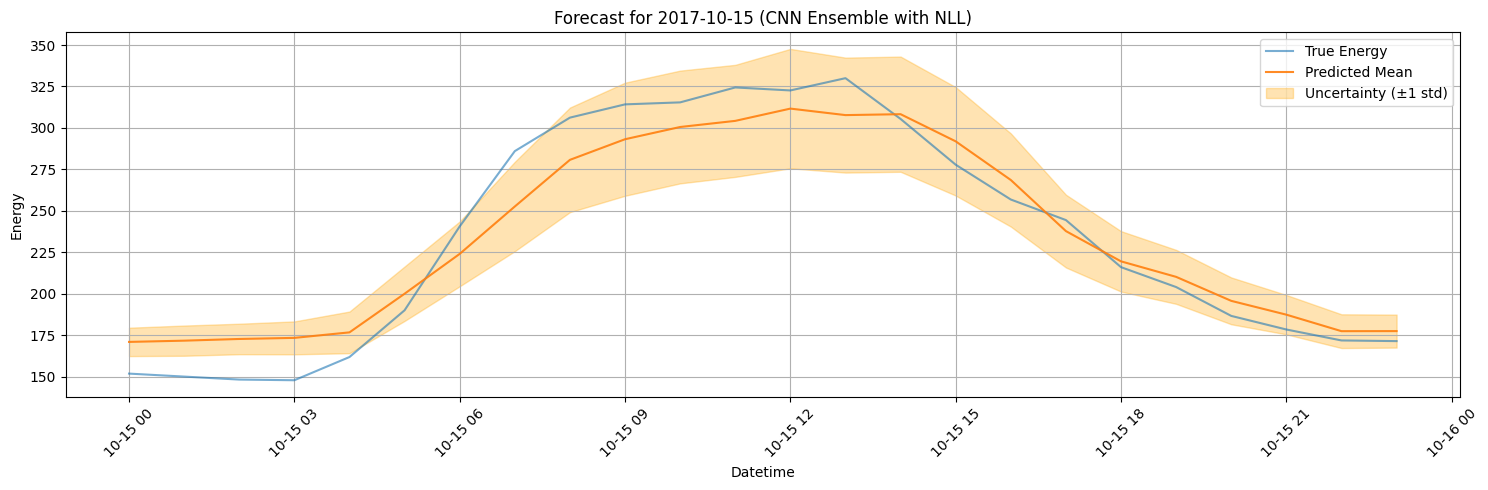

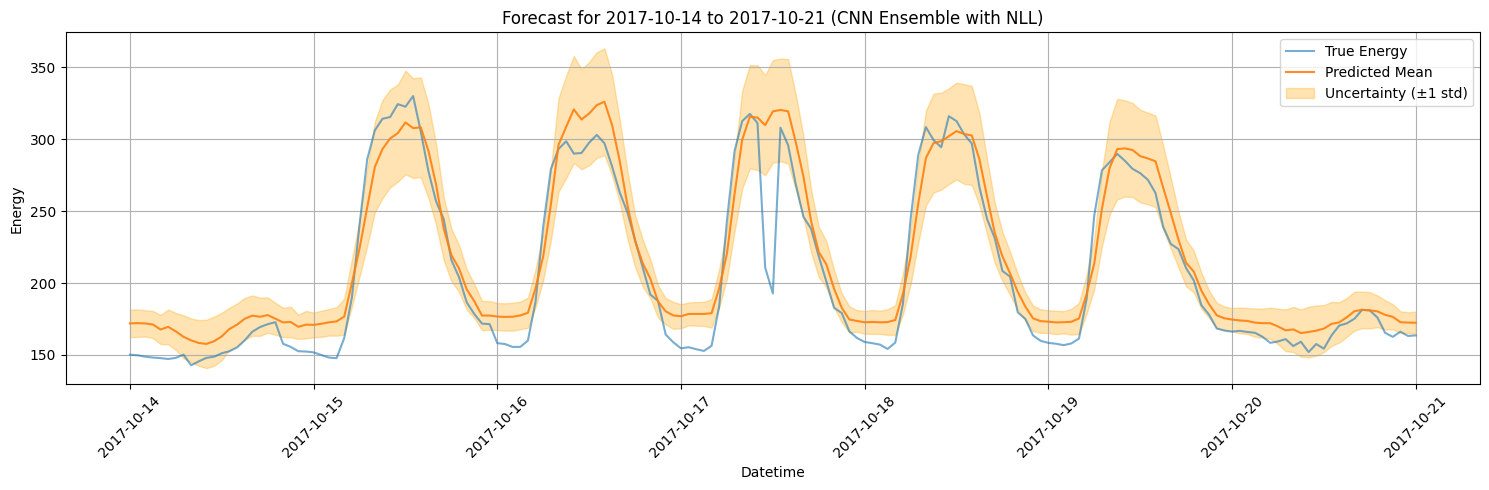

In [13]:
import matplotlib.pyplot as plt

# --- Plot for Specific Day: 2017-10-15 ---
specific_day = pd.to_datetime("2017-10-15").date()
mask_day = time_test.dt.date == specific_day

time_day = time_test[mask_day]
true_day = y_test[mask_day]
mean_day = mean_pred[mask_day]
std_day = std_pred[mask_day]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day, mean_day - std_day, mean_day + std_day,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-15 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot for Specific Week: 2017-10-14 to 2017-10-21 ---
start_date = pd.to_datetime("2017-10-14")
end_date = pd.to_datetime("2017-10-21")

mask_week = (time_test >= start_date) & (time_test <= end_date)

time_week = time_test[mask_week]
true_week = y_test[mask_week]
mean_week = mean_pred[mask_week]
std_week = std_pred[mask_week]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - std_week, mean_week + std_week,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-14 to 2017-10-21 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2 CNN

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
import tensorflow as tf
from datetime import timedelta

# --- Load data ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Feature Engineering ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    return df

df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed',
    'hour', 'weekday', 'is_weekend', 'is_holiday'
]

# --- Sliding Window ---
def create_sliding_windows_with_holiday(df, window_size, features, target):
    X, y, timestamps = [], [], []
    feature_array = df[features].values
    target_array = df[target].values
    datetime_array = pd.to_datetime(df['datetime'])
    for i in range(len(df) - window_size):
        X.append(feature_array[i:i + window_size])
        y.append(target_array[i + window_size])
        timestamps.append(datetime_array[i + window_size])
    return np.array(X), np.array(y), pd.Series(timestamps)

window_size = 48
X_train, y_train, _ = create_sliding_windows_with_holiday(df_Train, window_size, selected_features, 'energy')
X_val, y_val, _ = create_sliding_windows_with_holiday(df_Val, window_size, selected_features, 'energy')
X_test, y_test, time_test = create_sliding_windows_with_holiday(df_Test, window_size, selected_features, 'energy')

# --- Scaling for output ---
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- CNN Model with Two Outputs: mu and log_var ---
def build_cnn_with_nll():
    inputs = Input(shape=(window_size, len(selected_features)))
    x = layers.Conv1D(64, 3, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2)(x)  # [mu, log_var]
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=nll_loss)
    return model

# --- Train Ensemble ---
ensemble_models = []
n_ensemble = 2  # ✅ Only 2 CNN models
epochs = 30

for _ in range(n_ensemble):
    model = build_cnn_with_nll()
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- MC Dropout Prediction ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mu = predictions[:, :, 0].mean(axis=0)
    log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mu, std

# --- Get Ensemble Predictions ---
ensemble_preds = [mc_dropout_predict(model, X_test, n_iter=20) for model in ensemble_models]
mean_pred = np.mean([p[0] for p in ensemble_preds], axis=0)
std_pred = np.mean([p[1] for p in ensemble_preds], axis=0)

# --- Inverse Transform Output ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred ** 2 + 1e-3))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")


Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4809 - val_loss: 0.1315
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0743 - val_loss: 0.1390
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0248 - val_loss: 0.0207
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.1198 - val_loss: -0.0131
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.1416 - val_loss: -0.0939
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -0.2659 - val_loss: -0.0740
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -0.3059 - val_loss: -0.1231
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.2987 - val_loss: -0.3163
Epoch 9/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.3861 - val_loss: -0.1019
Epoch 10/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4112 - val_loss: -0.2387
Epoch 11/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4698 - val_loss: -0.1943
Epoch 12/30
365/365 ━━━━━━━━━━━━━━━

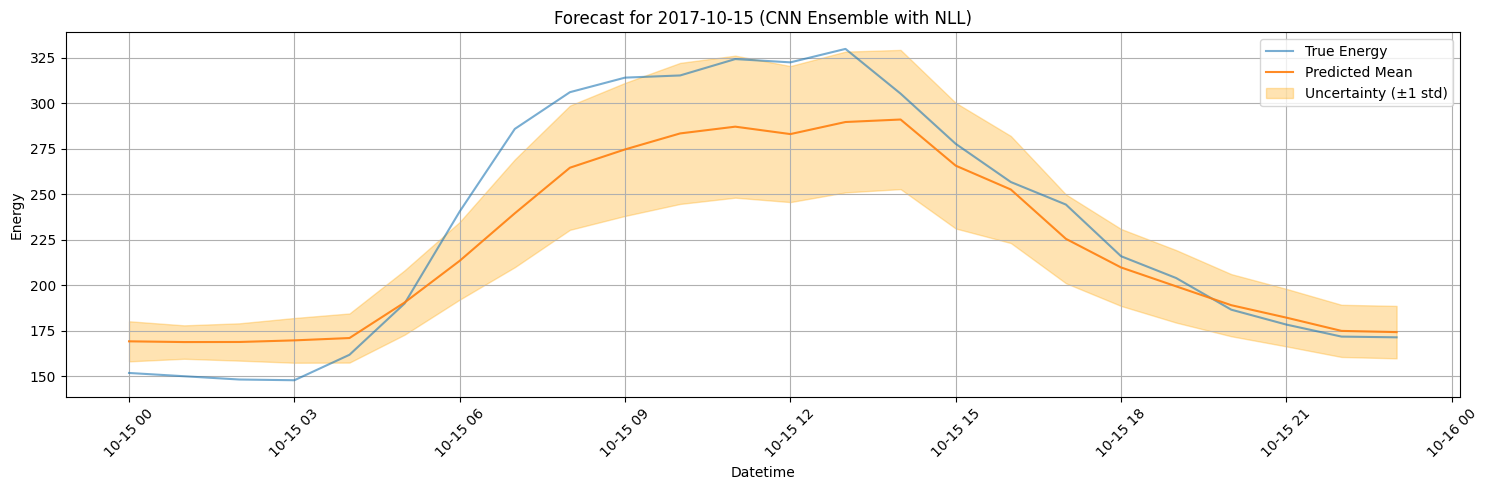

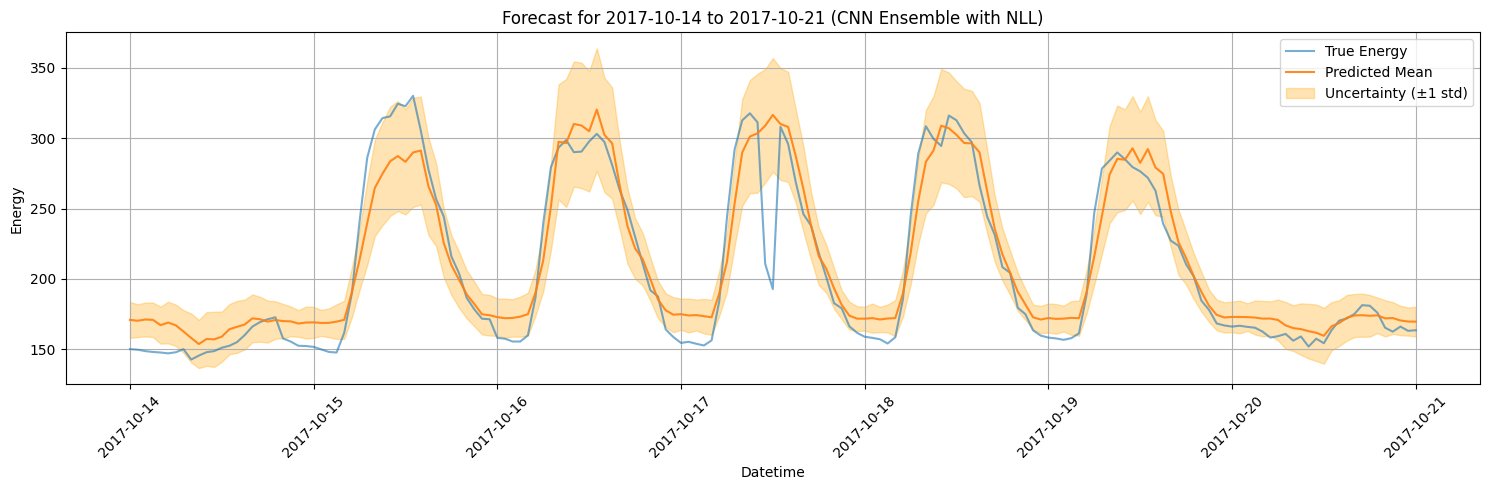

In [22]:
import matplotlib.pyplot as plt

# --- Plot for Specific Day: 2017-10-15 ---
specific_day = pd.to_datetime("2017-10-15").date()
mask_day = time_test.dt.date == specific_day

time_day = time_test[mask_day]
true_day = y_test[mask_day]
mean_day = mean_pred[mask_day]
std_day = std_pred[mask_day]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day, mean_day - std_day, mean_day + std_day,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-15 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot for Specific Week: 2017-10-14 to 2017-10-21 ---
start_date = pd.to_datetime("2017-10-14")
end_date = pd.to_datetime("2017-10-21")

mask_week = (time_test >= start_date) & (time_test <= end_date)

time_week = time_test[mask_week]
true_week = y_test[mask_week]
mean_week = mean_pred[mask_week]
std_week = std_pred[mask_week]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - std_week, mean_week + std_week,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-14 to 2017-10-21 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1 CNN

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
import tensorflow as tf

# --- Load data ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Feature Engineering ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    return df

df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed',
    'hour', 'weekday', 'is_weekend', 'is_holiday'
]

# --- Sliding Window ---
def create_sliding_windows_with_holiday(df, window_size, features, target):
    X, y, timestamps = [], [], []
    feature_array = df[features].values
    target_array = df[target].values
    datetime_array = pd.to_datetime(df['datetime'])
    for i in range(len(df) - window_size):
        X.append(feature_array[i:i + window_size])
        y.append(target_array[i + window_size])
        timestamps.append(datetime_array[i + window_size])
    return np.array(X), np.array(y), pd.Series(timestamps)

window_size = 48
X_train, y_train, _ = create_sliding_windows_with_holiday(df_Train, window_size, selected_features, 'energy')
X_val, y_val, _ = create_sliding_windows_with_holiday(df_Val, window_size, selected_features, 'energy')
X_test, y_test, time_test = create_sliding_windows_with_holiday(df_Test, window_size, selected_features, 'energy')

# --- Scaling for output ---
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- CNN Model (Single) ---
def build_cnn_with_nll():
    inputs = Input(shape=(window_size, len(selected_features)))
    x = layers.Conv1D(64, 3, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2)(x)  # [mu, log_var]
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=nll_loss)
    return model

# --- Train the Single Model ---
model = build_cnn_with_nll()
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# --- MC Dropout Prediction (Single Model) ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mu = predictions[:, :, 0].mean(axis=0)
    log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mu, std

# --- Predict ---
mean_pred, std_pred = mc_dropout_predict(model, X_test, n_iter=20)

# --- Inverse Transform Output ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = nll_loss(
    tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
    tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred ** 2 + 1e-3))), dtype=tf.float32)
).numpy()

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")


Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.3416 - val_loss: 0.1688
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0729 - val_loss: 0.0620
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.0758 - val_loss: -0.0703
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.1509 - val_loss: -0.0942
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.2080 - val_loss: -0.0812
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.2824 - val_loss: -0.1414
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.3672 - val_loss: -0.3276
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.4327 - val_loss: -0.0687
Epoch 9/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.4131 - val_loss: -0.2953
Epoch 10/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.4957 - val_loss: -0.1420
Epoch 11/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5184 - val_loss: -0.2469
Epoch 12/30
365/365 ━━━━━━━━━━━━━━

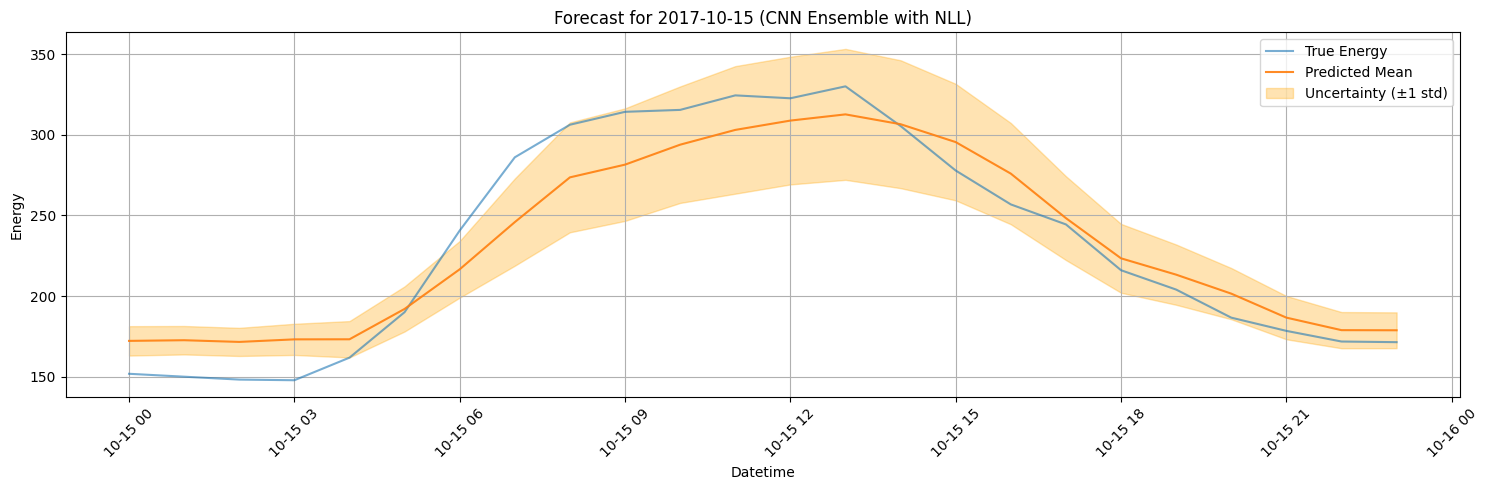

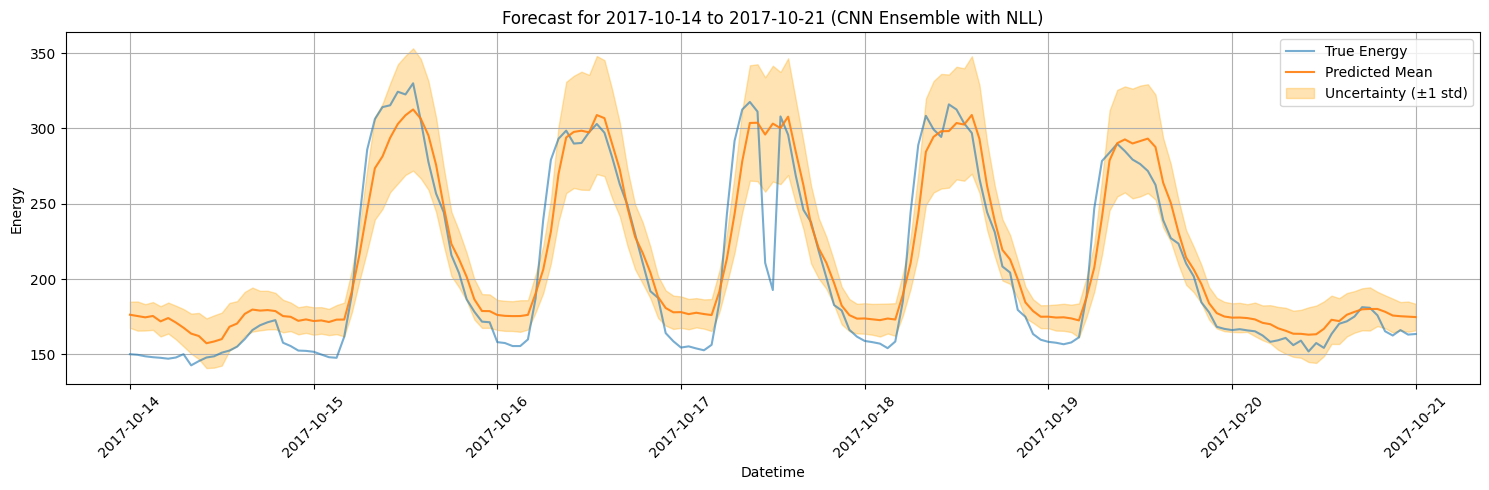

In [25]:

import matplotlib.pyplot as plt

# --- Plot for Specific Day: 2017-10-15 ---
specific_day = pd.to_datetime("2017-10-15").date()
mask_day = time_test.dt.date == specific_day

time_day = time_test[mask_day]
true_day = y_test[mask_day]
mean_day = mean_pred[mask_day]
std_day = std_pred[mask_day]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day, mean_day - std_day, mean_day + std_day,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-15 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot for Specific Week: 2017-10-14 to 2017-10-21 ---
start_date = pd.to_datetime("2017-10-14")
end_date = pd.to_datetime("2017-10-21")

mask_week = (time_test >= start_date) & (time_test <= end_date)

time_week = time_test[mask_week]
true_week = y_test[mask_week]
mean_week = mean_pred[mask_week]
std_week = std_pred[mask_week]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - std_week, mean_week + std_week,
                 color='orange', alpha=0.3, label="Uncertainty (±1 std)")
plt.title("Forecast for 2017-10-14 to 2017-10-21 (CNN Ensemble with NLL)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## *K) LSTM Neural network and the 


5 LSTM 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, optimizers, Input
from datetime import timedelta
import tensorflow as tf
# --- Load datasets ---
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")

# --- Load holiday and weekend dataset ---
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Selected features ---
selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed', 'hour', 'weekday',
    'is_weekend', 'is_holiday', 'is_long_holiday', 'avg_temperature'
]

# --- Prepare the weekend and holiday feature ---
def create_weekend_holiday_feature(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['is_long_holiday'] = df['is_holiday'].rolling(window=7).sum().ffill()
    if 'air_temperature' in df.columns:
        df['avg_temperature'] = df['air_temperature'].rolling(window=7).mean().ffill()
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
    return df

# --- Apply to all datasets ---
df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

# --- Normalize data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full = df_Train[selected_features].values
y_train_full = df_Train['energy'].values.reshape(-1, 1)
X_val_full = df_Val[selected_features].values
y_val_full = df_Val['energy'].values.reshape(-1, 1)
X_test_full = df_Test[selected_features].values
y_test_full = df_Test['energy'].values.reshape(-1, 1)

X_train_full = scaler_X.fit_transform(X_train_full)
X_val_full = scaler_X.transform(X_val_full)
X_test_full = scaler_X.transform(X_test_full)
y_train_full = scaler_y.fit_transform(y_train_full)
y_val_full = scaler_y.transform(y_val_full)
y_test_full = scaler_y.transform(y_test_full)

# --- Sliding Window Function ---
def create_sliding_windows_with_holiday(X_full, y_full, window_size, timestamps):
    X, y = [], []
    for i in range(len(X_full) - window_size):
        X.append(X_full[i:i + window_size])
        y.append(y_full[i + window_size])
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 168  # 7 days (hours)

# --- Create sliding windows ---
X_train, y_train = create_sliding_windows_with_holiday(X_train_full, y_train_full, window_size, df_Train['datetime'])
X_val, y_val = create_sliding_windows_with_holiday(X_val_full, y_val_full, window_size, df_Val['datetime'])
X_test, y_test = create_sliding_windows_with_holiday(X_test_full, y_test_full, window_size, df_Test['datetime'])
time_test = pd.Series(pd.to_datetime(df_Test['datetime'])[window_size:])

# --- Reshape for LSTM ---
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(selected_features)))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(selected_features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(selected_features)))
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# --- NLL Loss Function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-3
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- LSTM Model with MC-Dropout ---
def build_lstm_with_dropout(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.LSTM(50, return_sequences=False, dropout=0.3)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, kernel_initializer='glorot_normal')(x)
    model = models.Model(inputs, outputs)
    optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=nll_loss)
    return model

# --- Train Ensemble of LSTM Models ---
ensemble_models = []
n_ensemble = 5
epochs = 30

for _ in range(n_ensemble):
    model = build_lstm_with_dropout((window_size, len(selected_features)))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- MC Dropout Prediction with Uncertainty ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mean_mu = predictions[:, :, 0].mean(axis=0)
    mean_log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(mean_log_var) + 1e-3
    std = np.sqrt(var.numpy())
    return mean_mu, std

# --- Get Ensemble Predictions ---
ensemble_preds = [mc_dropout_predict(model, X_test, n_iter=20) for model in ensemble_models]
mean_pred = np.mean([pred[0] for pred in ensemble_preds], axis=0)
std_pred = np.mean([pred[1] for pred in ensemble_preds], axis=0)

# --- Inverse transform predictions ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred**2 + 1e-3))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")

# --- Plot Forecast for 1 Week ---
week_indices = (time_test >= time_test.iloc[0]) & (time_test < time_test.iloc[0] + timedelta(weeks=1))
time_week = time_test[week_indices]
true_week = y_test[week_indices]
mean_week = mean_pred[week_indices]
std_week = std_pred[week_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - 1.96 * std_week, mean_week + 1.96 * std_week,
                 color='orange', alpha=0.3, label="95% CI")
plt.title("Forecast for 1 Week (Deep Ensemble LSTM with Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Forecasts Over Multiple Time Spans ---
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta
    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range, mean_values - 1.96 * std_values, mean_values + 1.96 * std_values,
                     color='orange', alpha=0.3, label="95% CI")
    plt.title(f"Forecast for {label} (Deep Ensemble LSTM with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.3911 - val_loss: -0.0066
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0.0467 - val_loss: -0.0427
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: -0.0361 - val_loss: -0.0932
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: -0.1071 - val_loss: -0.1723
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: -0.0995 - val_loss: -0.2056
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: -0.1492 - val_loss: -0.0670
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: -0.1704 - val_loss: -0.2343
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: -0.2171 - val_loss: -0.1022
Epoch 9/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: -0.2379 - val_loss: -0.2663
Epoch 10/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: -0.2550 - val_loss: -0.2442
Epoch 11/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: -0.2616 - val_loss: -0.2487
Epoch 12/3

In [10]:
# Check the columns in your dataset to see if 'temperature' exists
print("Columns in df_Train:", df_Train.columns)

# Display a few rows of the data to inspect its structure
print(df_Train.head())


Columns in df_Train: Index(['datetime', 'energy', 'air_temperature', 'diffuse_r', 'elspot',
       'full_solar', 'global_r', 'gust_speed', 'relative_humidity', 'sunshine',
       'wind_speed', 'is_weekend', 'is_holiday', 'is_long_holiday',
       'avg_temperature', 'hour', 'weekday'],
      dtype='object')
             datetime  energy  air_temperature  diffuse_r    elspot  \
0 2018-11-16 00:00:00   161.6         0.326873  -0.528883  0.149584   
1 2018-11-16 01:00:00   160.6         0.315406  -0.530350  0.127610   
2 2018-11-16 02:00:00   160.2         0.303940  -0.525950  0.136156   
3 2018-11-16 03:00:00   159.0         0.303940  -0.524483  0.164843   
4 2018-11-16 04:00:00   158.0         0.303940  -0.525950  0.274100   

   full_solar  global_r  gust_speed  relative_humidity  sunshine  wind_speed  \
0   -0.456244 -0.491608    1.855847           0.218629 -0.455473    2.123126   
1   -0.456235 -0.491033    1.488741           0.162524 -0.455473    1.523551   
2   -0.456209 -0.490459  

Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - loss: 1.3175 - val_loss: 0.0427 - learning_rate: 5.0000e-04
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 57s 161ms/step - loss: 0.1485 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - loss: 0.0070 - val_loss: -0.0666 - learning_rate: 5.0000e-04
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - loss: -0.0905 - val_loss: -0.1688 - learning_rate: 5.0000e-04
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 61s 170ms/step - loss: -0.1206 - val_loss: -0.2146 - learning_rate: 5.0000e-04
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - loss: -0.1586 - val_loss: -0.2568 - learning_rate: 5.0000e-04
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - loss: -0.2189 - val_loss: -0.2504 - learning_rate: 5.0000e-04
Epoch 8/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - loss: -0.2701 - val_loss: -0.2669 - learning_rate: 5.0000e-04
Epoch 9/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/ste

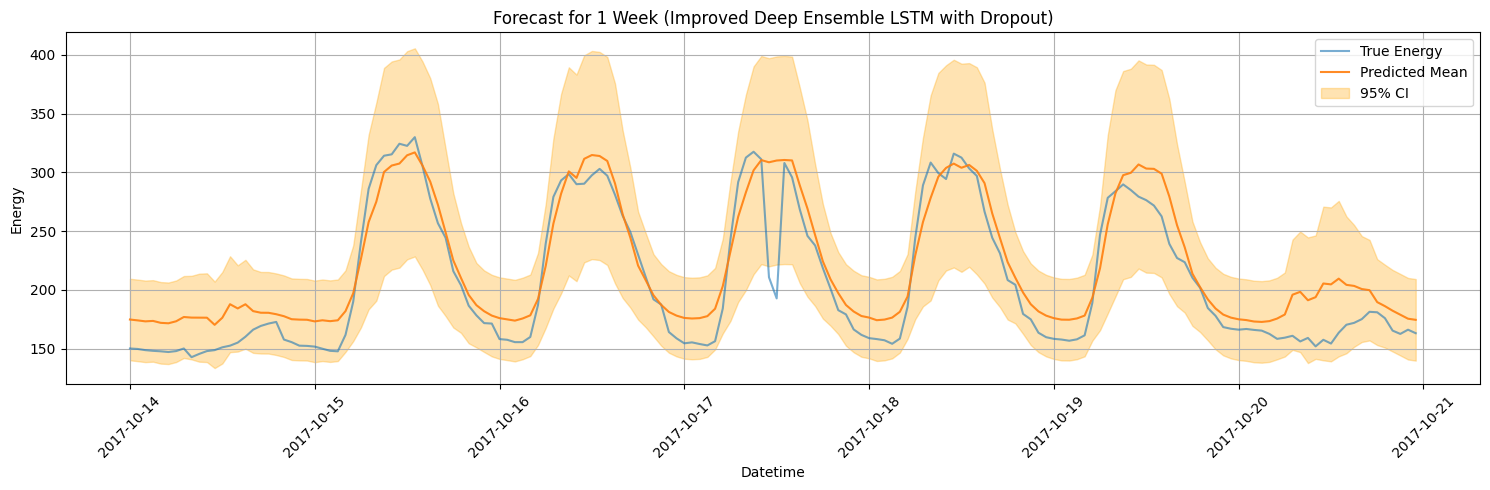

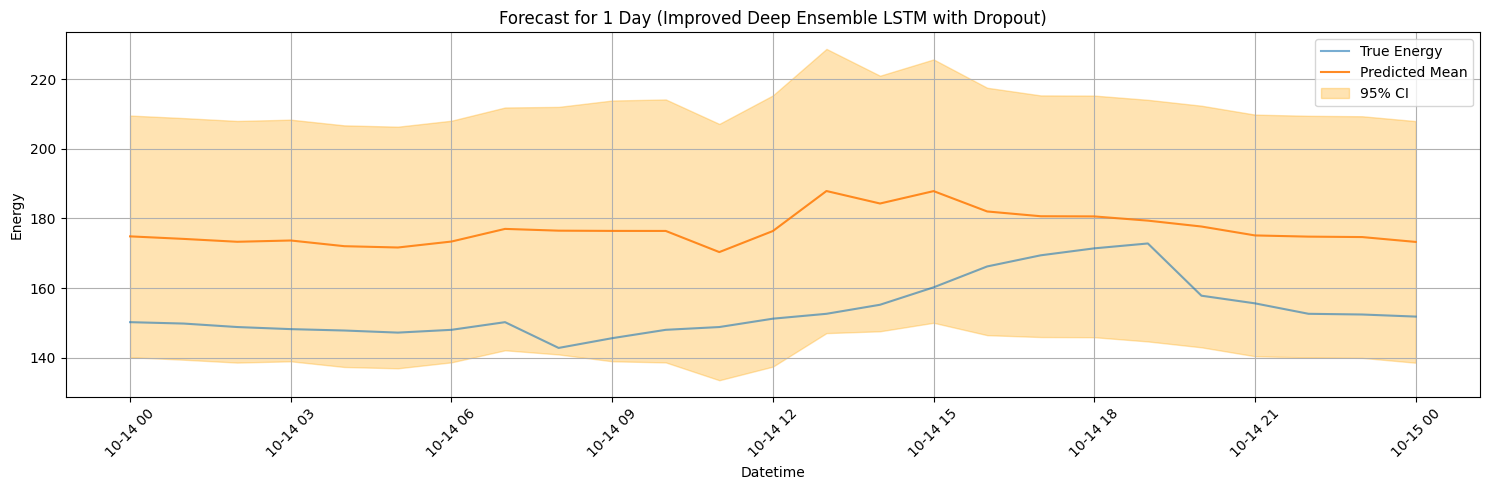

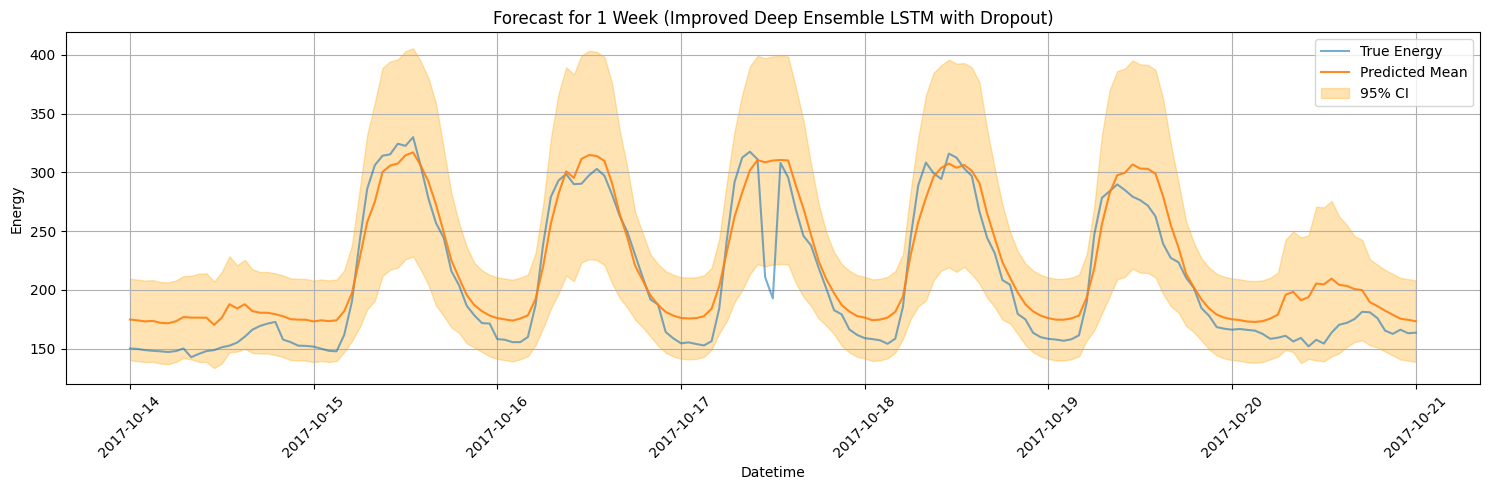

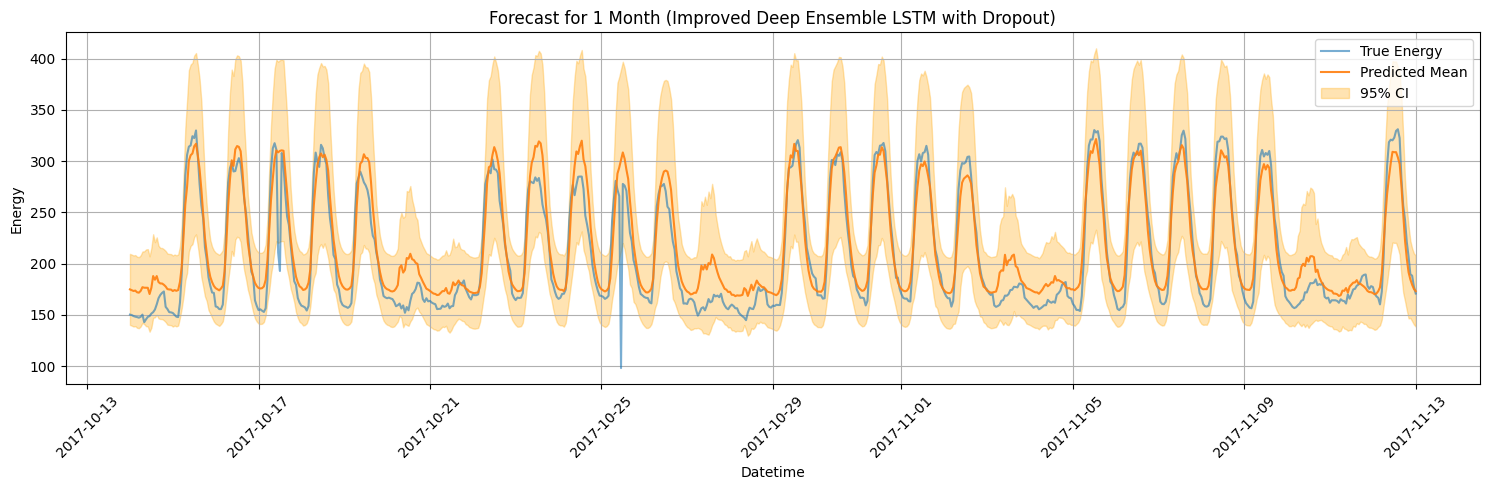

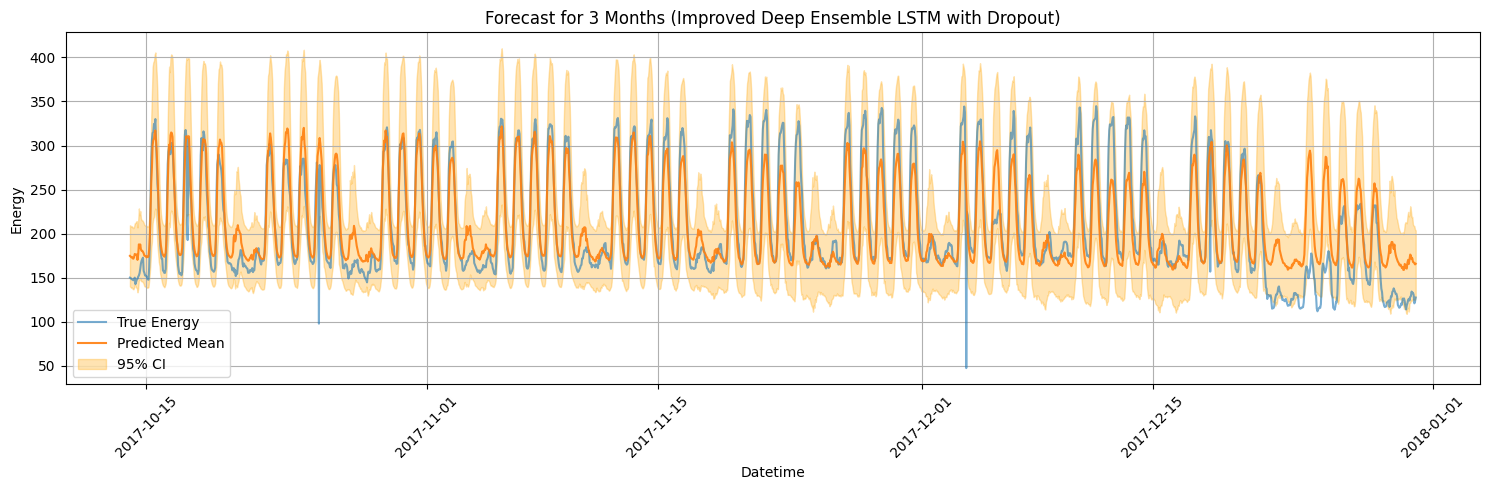

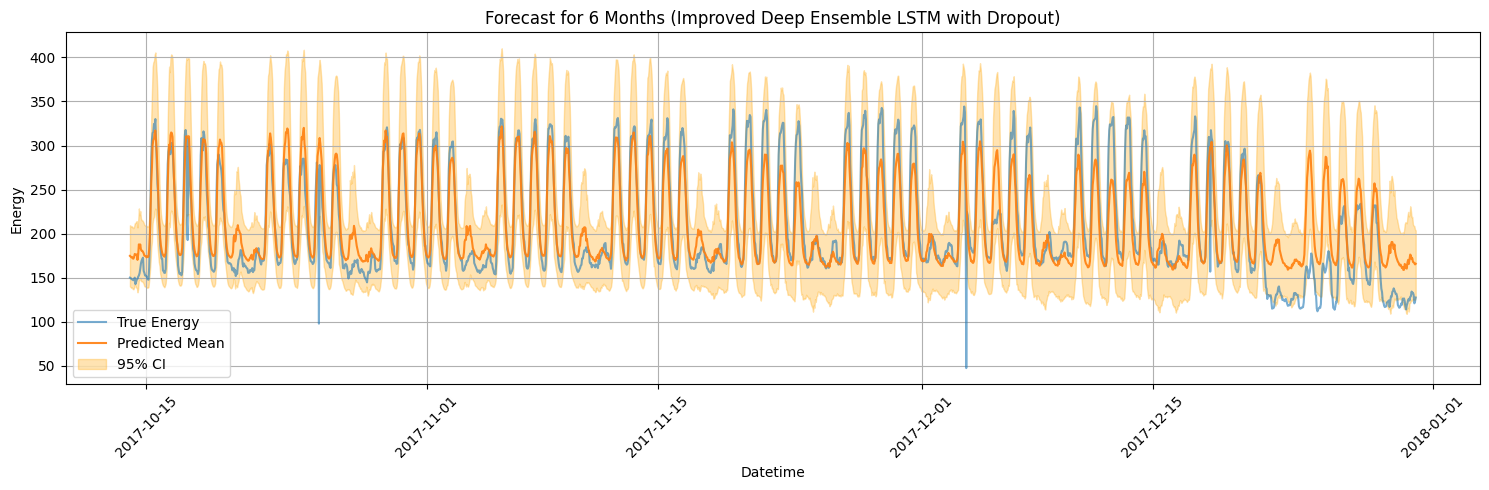

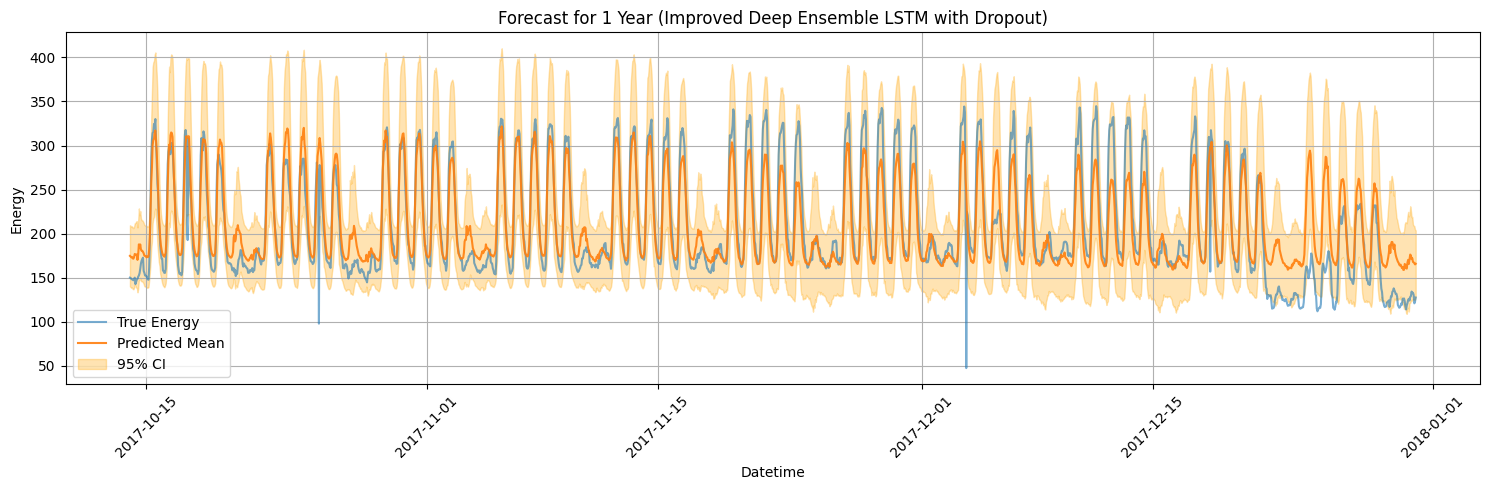

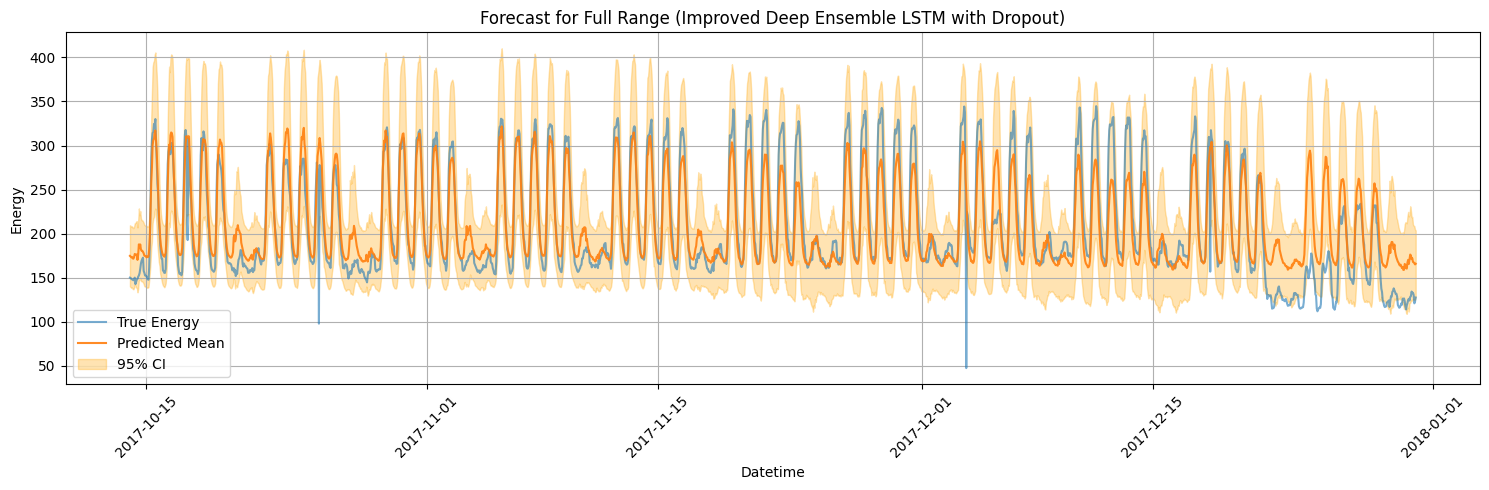

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, optimizers, Input, callbacks
from datetime import timedelta
import tensorflow as tf

# --- Load holiday and weekend dataset ---
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')

# --- Prepare enhanced features ---
def create_enhanced_features(df, holidays_df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)
    df['is_long_holiday'] = df['is_holiday'].rolling(window=7).sum().ffill()
    if 'air_temperature' in df.columns:
        df['avg_temperature'] = df['air_temperature'].rolling(window=7).mean().ffill()
    df['temp_lag1'] = df['air_temperature'].shift(1).ffill()
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df['month'] = df['datetime'].dt.month
    df['is_peak_hour'] = df['hour'].isin([8, 9, 17, 18]).astype(int)
    df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
    return df

# --- Selected features ---
selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed', 'hour', 'weekday',
    'month', 'is_weekend', 'is_holiday', 'is_long_holiday', 'avg_temperature',
    'temp_lag1', 'is_peak_hour'
]

# --- Apply feature engineering ---
df_Train = create_enhanced_features(df_Train, holidays_df)
df_Val = create_enhanced_features(df_Val, holidays_df)
df_Test = create_enhanced_features(df_Test, holidays_df)

# --- Normalize data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full = scaler_X.fit_transform(df_Train[selected_features])
X_val_full = scaler_X.transform(df_Val[selected_features])
X_test_full = scaler_X.transform(df_Test[selected_features])

y_train_full = scaler_y.fit_transform(df_Train['energy'].values.reshape(-1, 1))
y_val_full = scaler_y.transform(df_Val['energy'].values.reshape(-1, 1))
y_test_full = scaler_y.transform(df_Test['energy'].values.reshape(-1, 1))

# --- Sliding window function ---
def create_sliding_windows(X_full, y_full, window_size):
    X, y = [], []
    for i in range(len(X_full) - window_size):
        X.append(X_full[i:i + window_size])
        y.append(y_full[i + window_size])
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 336  # 14 days (hourly data)

# --- Create sliding windows ---
X_train, y_train = create_sliding_windows(X_train_full, y_train_full, window_size)
X_val, y_val = create_sliding_windows(X_val_full, y_val_full, window_size)
X_test, y_test = create_sliding_windows(X_test_full, y_test_full, window_size)
time_test = pd.Series(pd.to_datetime(df_Test['datetime'])[window_size:])

# --- Reshape for LSTM ---
X_train = X_train.reshape((-1, window_size, len(selected_features)))
X_val = X_val.reshape((-1, window_size, len(selected_features)))
X_test = X_test.reshape((-1, window_size, len(selected_features)))
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# --- NLL loss function ---
@tf.function
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.nn.softplus(log_var) + 1e-2
    return tf.reduce_mean(0.5 * (tf.math.log(var) + tf.square(y_true - mu) / var))

# --- Build model ---
def build_lstm_with_dropout(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.LSTM(100, return_sequences=True, dropout=0.3)(inputs)
    x = layers.LSTM(50, return_sequences=False, dropout=0.3)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, kernel_initializer='glorot_normal',
                           bias_initializer=tf.keras.initializers.Constant(value=[0.0, -2.0]))(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss=nll_loss)
    return model

# --- Callbacks ---
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train ensemble ---
ensemble_models = []
n_ensemble = 7
epochs = 50

for _ in range(n_ensemble):
    model = build_lstm_with_dropout((window_size, len(selected_features)))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[lr_scheduler, early_stopping], verbose=1)
    ensemble_models.append(model)

# --- MC dropout prediction ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy() for _ in range(n_iter)])
    mean_mu = predictions[:, :, 0].mean(axis=0)
    mean_log_var = predictions[:, :, 1].mean(axis=0)
    var = tf.nn.softplus(mean_log_var) + 1e-2
    std = np.sqrt(var.numpy())
    std = np.clip(std, np.percentile(std, 25), np.percentile(std, 75))
    return mean_mu, std

# --- Get ensemble predictions ---
ensemble_preds = [mc_dropout_predict(model, X_test, n_iter=20) for model in ensemble_models]
mean_pred = np.mean([pred[0] for pred in ensemble_preds], axis=0)
std_pred = np.mean([pred[1] for pred in ensemble_preds], axis=0)

# --- Inverse transform predictions ---
mean_pred = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
std_pred = std_pred * scaler_y.scale_[0]

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
nll = np.mean([
    nll_loss(
        tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32),
        tf.convert_to_tensor(np.column_stack((mean_pred, np.log(std_pred**2 + 1e-2))), dtype=tf.float32)
    ).numpy() for _ in ensemble_models
])
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ NLL: {nll:.2f}")

# --- Plot: 1 Week Forecast ---
week_indices = (time_test >= time_test.iloc[0]) & (time_test < time_test.iloc[0] + timedelta(weeks=1))
time_week = time_test[week_indices]
true_week = y_test[week_indices]
mean_week = mean_pred[week_indices]
std_week = std_pred[week_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_week, true_week, label="True Energy", alpha=0.6)
plt.plot(time_week, mean_week, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_week, mean_week - 1.96 * std_week, mean_week + 1.96 * std_week,
                 color='orange', alpha=0.3, label="95% CI")
plt.title("Forecast for 1 Week (Improved Deep Ensemble LSTM with Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot: Multiple Time Horizons ---
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta

    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range, mean_values - 1.96 * std_values, mean_values + 1.96 * std_values,
                     color='orange', alpha=0.3, label="95% CI")
    plt.title(f"Forecast for {label} (Improved Deep Ensemble LSTM with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


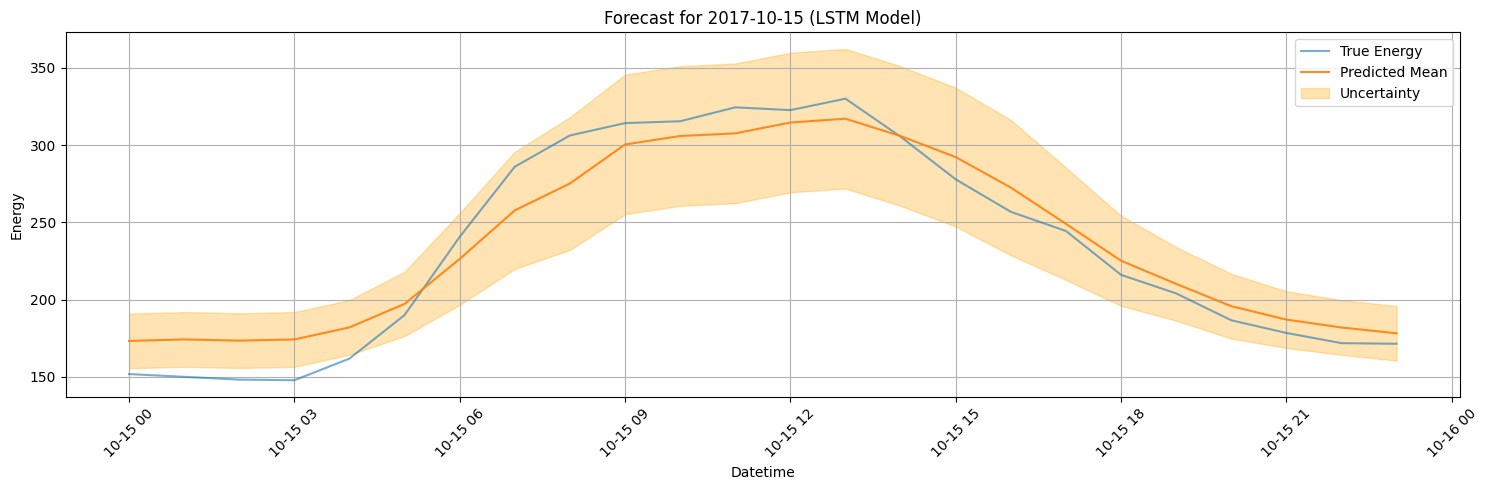

In [28]:
# Replace with a valid date based on output above
target_date = pd.to_datetime("2017-10-15")

day_indices = time_test.dt.date == target_date.date()
time_day = time_test[day_indices]
true_day = y_test[day_indices]
mean_day = mean_pred[day_indices]
std_day = std_pred[day_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day, mean_day - std_day, mean_day + std_day,
                 color='orange', alpha=0.3, label="Uncertainty")
plt.title(f"Forecast for {target_date.date()} (LSTM Model)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
